# Vinted Seller Shipping Performance 
### Analysis of **Shipping Time and Non-Shipment Correlation**

This analysis reveals a strong correlation between delayed shipping and non-shipment cancellations on Vinted. Specifically, sellers who do not ship within 3 days are significantly more likely to cancel orders due to seller failure, impacting buyer trust and overall platform success. I've identified key areas for intervention that could improve shipping reliability and reduce cancellations.

### Project Goal: 
To analyze the time taken for Vinted sellers to ship items and determine if there's a correlation between delayed initial shipping (e.g., beyond 3 days) and the likelihood of an item never being shipped at all.

#### Key Questions to Answer:

1. What is the average shipping time for sellers on Vinted?
2. What is the distribution of shipping times (e.g., how many ship within 1 day, 2 days, etc.)?
3. What percentage of orders are canceled due to non-shipment?
4. Is there a statistically significant difference in the non-shipment rate for sellers who ship within the first 3 days compared to those who don't?
5. Are there specific item categories, price points, or seller characteristics that are associated with longer shipping times or higher non-shipment rates?

---

## 1. Data Generation:

To ensure a controlled environment for analysis and demonstrate the methodology, a simulated dataset was generated with realistic Vinted order characteristics.

#### Simulation Strategy:

1. **Define Core Parameters:** Set up the number of orders, time ranges, and probabilities for various events (e.g., shipping within 3 days, cancellation rates).
2. **Generate Orders:** Create a base of orders with *order_id*, *seller_id*, *buyer_id*, and *order_date*.
3. **Simulate Shipping Times:**
    - Most orders will ship within 1-2 days.
    - A smaller percentage will ship within 3-5 days.
    - A small percentage will be "delayed but shipped".
    - A portion will be *"never shipped."*
4. **Simulate Cancellations:** Assign cancellation reasons, with a focus on "seller did not ship in time" for the "never shipped" items.
5. **Simulate Item and Seller Attributes:** Add *item_category*, *item_price*, *seller_rating*, and *seller_total_sales*.
6. **Calculate Derived Fields:** Compute *days_to_ship*, *is_shipped*, and *shipped_within_3_days*.

#### Simulated Dataset with the following columns:

- ***order_id***: Unique identifier for each order.
- ***seller_id***: Unique identifier for the seller.
- ***buyer_id***: Unique identifier for the buyer.
- ***order_date***: Date and time the order was placed.
- ***shipment_date***: Date and time the item was marked as shipped.
- ***cancellation_date***: Date and time the order was canceled.
- ***cancellation_reason***: Reason for cancellation
- ***item_category:*** E.g., "Women's Clothing," "Men's Shoes," "Home Decor."
- ***item_price:*** Price of the item.
- ***seller_rating:*** Current average seller rating (out of 5 stars).
- ***seller_total_sales:*** Number of previous sales by the seller.
- ***vinted_shipping_deadline:*** 5 business days to ship.
- ***is_shipped:*** Boolean (True/False) indicating if the item was shipped.
- ***days_to_ship:*** Calculated field: shipment_date - order_date.
- ***shipped_within_3_days:*** Boolean (True/False) if days_to_ship <= 3.

**Simulation Code in an Attachment:** vinted_orders_data_simulation.ipynb

---

## Python Code for Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [3]:
%load_ext blackcellmagic

## 2. Load & Display Data

First, we load the simulated order data and inspect its structure to ensure it's ready for analysis. We'll check the first few rows and column data types.

In [4]:
# Load CSV file
df = pd.read_csv("vinted_orders_simulated_data.csv")
df.head()

,order_id,seller_id,buyer_id,order_date,shipment_date,cancellation_date,cancellation_reason,item_category,item_price,seller_rating,seller_total_sales,vinted_shipping_deadline_days,days_to_ship,is_shipped,is_never_shipped,shipped_within_3_days
0,ceb07575-b634-4fc2-ae9b-a26dd78ef6ac,8e32685b-1a1e-4e8f-a6c9-e7814cb1bc09,95a7901a-3657-4d43-9c8d-3e128a85e9bf,2024-10-06,2024-10-07,NaN,NaN,Bags,27.14,5.0,222,5,0.0,True,False,True
1,d9a01db6-1332-4985-ab5e-4f69eea19659,7d2e2394-4b5f-4c01-9a29-8c9bc64be52d,98ac3347-795a-466d-8843-e0dd43e16624,2024-08-21,2024-08-22,NaN,NaN,Beauty Products,16.02,3.5,435,5,1.0,True,False,True
2,853530a8-6255-42bf-87ee-6696468d0121,340446cd-ff3e-4289-a90f-485c69eb86f1,cbe3440c-91f0-4066-9fac-1cdd96530604,2025-02-24,2025-02-24,NaN,NaN,Women's Clothing,63.14,4.7,153,5,0.0,True,False,True
3,07e5ce64-e691-478e-9d98-e09884630419,eff9a7ec-a208-420b-8e2b-b956cf27b4a6,658075ba-ea9c-499f-8da0-0d4023a87212,2024-01-08,2024-01-09,NaN,NaN,Books,7.46,3.0,132,5,1.0,True,False,True
4,abfa3404-20a8-4dbe-88f4-1ce7a5a058d1,00d6510c-3c81-439a-84ec-d7ada5afeecc,5541c656-9931-4288-9048-44af3e603b05,2024-09-01,2024-09-03,NaN,NaN,Women's Shoes,5.00,4.2,492,5,1.0,True,False,True


In [5]:
# Display basic info about the generated data
print(f"Generated {len(df)} orders.")
print(f"\nDataFrame Info:")
df.info()

Generated 10000 orders.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       10000 non-null  object 
 1   seller_id                      10000 non-null  object 
 2   buyer_id                       10000 non-null  object 
 3   order_date                     10000 non-null  object 
 4   shipment_date                  9494 non-null   object 
 5   cancellation_date              506 non-null    object 
 6   cancellation_reason            506 non-null    object 
 7   item_category                  10000 non-null  object 
 8   item_price                     10000 non-null  float64
 9   seller_rating                  10000 non-null  float64
 10  seller_total_sales             10000 non-null  int64  
 11  vinted_shipping_deadline_days  10000 non-null  int64  
 12  days_t

##### **Data Overview Summary:**   
The dataset contains 10,000 orders with key details on shipment, cancellation, item, and seller attributes. Notably, there are some missing values in *shipment_date* and *cancellation_date/reason*, which are expected for *non-shipped* or *non-canceled orders*, respectively.

---

## 3. Data Cleaning

#### 3.1. Converting data types to ensure proper analysis and efficient storage

In [6]:
string_columns = ["order_id", "seller_id", "buyer_id"]
df[string_columns] = df[string_columns].astype("string")

date_columns = ["order_date", "shipment_date", "cancellation_date"]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors="coerce")

categorical_columns = ["cancellation_reason", "item_category"]
df[categorical_columns] = df[categorical_columns].astype("category")

# Convert shipping days to a nullable 'integer' type
df["days_to_ship"] = df["days_to_ship"].astype("Int64")

In [7]:
df.dtypes

order_id                         string[python]
seller_id                        string[python]
buyer_id                         string[python]
order_date                       datetime64[ns]
shipment_date                    datetime64[ns]
cancellation_date                datetime64[ns]
cancellation_reason                    category
item_category                          category
item_price                              float64
seller_rating                           float64
seller_total_sales                        int64
vinted_shipping_deadline_days             int64
days_to_ship                              Int64
is_shipped                                 bool
is_never_shipped                           bool
shipped_within_3_days                      bool
dtype: object

##### **Data types confirmed for correct analysis.**

---

#### 3.2. Outliers Overview

In [8]:
# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df_numeric_subset = df_numeric.drop(columns=["vinted_shipping_deadline_days"])

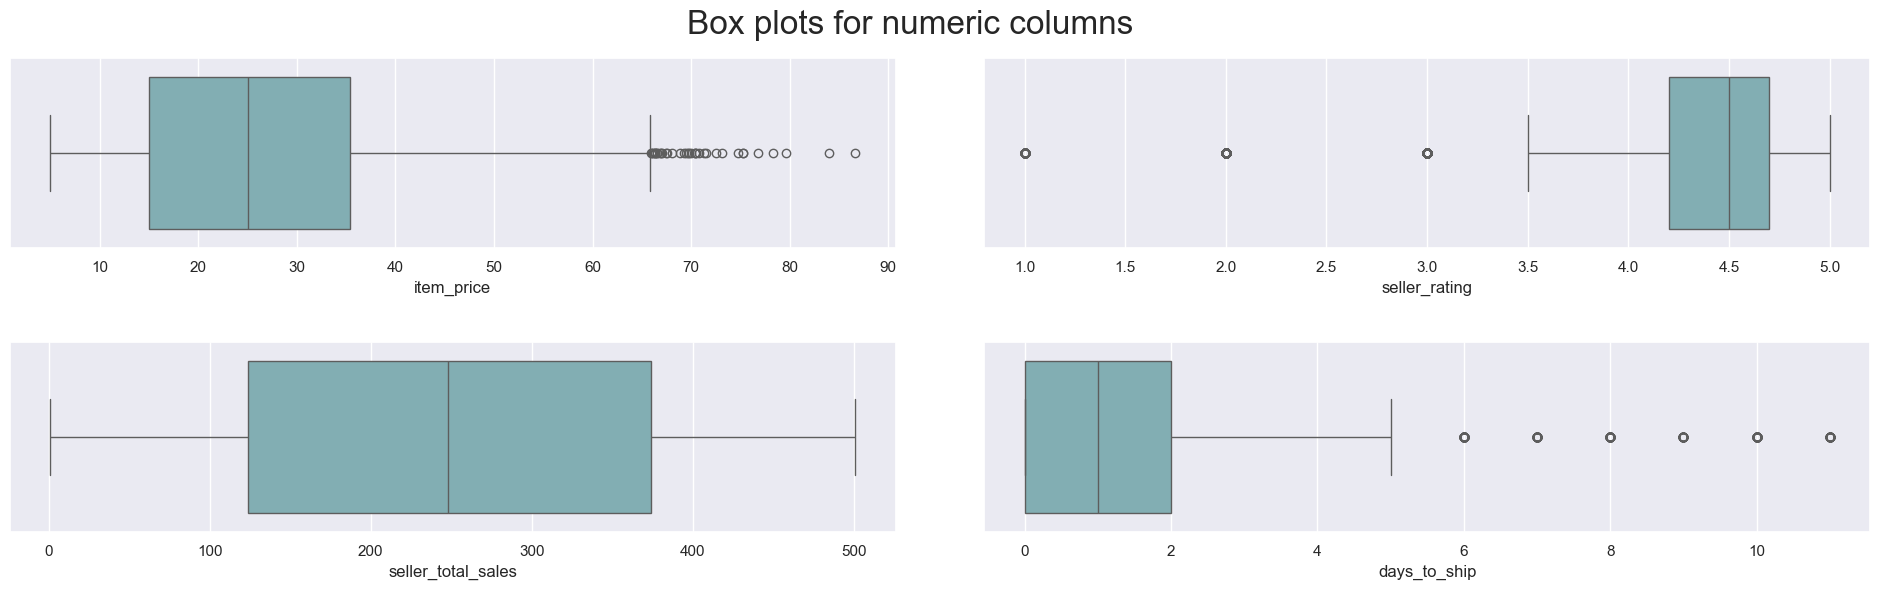

In [9]:
# Plot outliers visualization
sns.set_theme()

num_rows = 2
num_cols = 2

fig, ax = plt.subplots(figsize=(24, 6), nrows=num_rows, ncols=num_cols)

fig.suptitle("Box plots for numeric columns", fontsize=24)

for i, col in enumerate(df_numeric_subset.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df_numeric_subset, x=col, color="#7AB5BB")

plt.subplots_adjust(top=0.9, wspace=0.1, hspace=0.5)

- The identified outliers (particularly in *days_to_ship* and *seller_rating*) are relevant to the analysis. Given their volume and magnitude, removing them could significantly skew descriptive statistics, such as the mean, and potentially bias results related to seller behavior comparisons.

---

As this is a simulated dataset, we have confirmed that the data generation process ensures the absence of missing values and duplicates. Therefore, standard data cleaning steps for handling nulls and removing duplicates have been intentionally omitted.

---

## 4. Exploratory Data Analysis

#### 4.1. Shipping Time: Mean, Median and Mode

In [10]:
# Mean, Median, Mode
mean_days = df["days_to_ship"].mean()
median_days = df["days_to_ship"].median()
mode_days = df["days_to_ship"].mode().tolist()

print(f"Mean business days to ship: {mean_days:.2f}")
print(f"Median business days to ship: {median_days}")
print(f"Mode(s) business days to ship: {mode_days}")

Mean business days to ship: 1.46
Median business days to ship: 1.0
Mode(s) business days to ship: [0]


---

#### 4.2 Shipping Time Distribution

In [11]:
# Filter only shipped items with valid shipping time
shipped_df = df[df["is_shipped"] & df["days_to_ship"].notna()]

In [12]:
def analyze_shipping_time_distribution(dataframe):
    """
    Analyzes the distribution of 'days_to_ship' for shipped items,
    displaying both counts and percentages in a formatted DataFrame.
    """
    shipping_time_counts = shipped_df["days_to_ship"].value_counts().sort_index()
    shipping_time_percentages = (
        shipped_df["days_to_ship"].value_counts(normalize=True).sort_index() * 100
    )

    distribution_df = pd.DataFrame(
        {"Count": shipping_time_counts, "Percentage": shipping_time_percentages}
    )

    distribution_df["Percentage"] = distribution_df["Percentage"].apply(
        lambda x: f"{x:.2f}%"
    )
    distribution_df.index.name = "Business Days to Ship"

    return distribution_df

In [13]:
print(analyze_shipping_time_distribution(shipped_df))
print(f"Total shipped orders: {len(shipped_df)}")

                       Count Percentage
Business Days to Ship                  
0                       3513     37.00%
1                       2569     27.06%
2                       1518     15.99%
3                       1063     11.20%
4                        307      3.23%
5                        168      1.77%
6                         71      0.75%
7                         55      0.58%
8                         69      0.73%
9                         40      0.42%
10                        74      0.78%
11                        47      0.50%
Total shipped orders: 9494


---

#### 4.3 Shipping Time Distribution Visualization

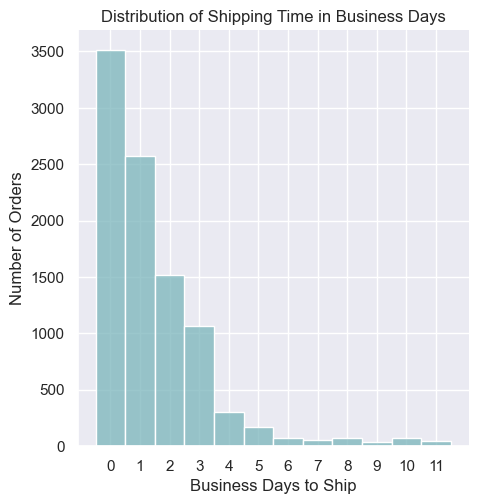

In [14]:
#Plot Distribution Histogram
sns.set_theme()

max_day = shipped_df["days_to_ship"].max()
bin_edges = np.arange(-0.5, max_day + 1.5)

sns.displot(
    shipped_df["days_to_ship"],
    bins=bin_edges,
    kde=False,
    color="#7AB5BB"
)

plt.title("Distribution of Shipping Time in Business Days")
plt.xlabel("Business Days to Ship")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.xticks(range(max_day + 1))

plt.show()

- **80% of Orders Shipped within 3 Business Days.** (7,600 out of 9,494)
- **The most frequent shipping time is 0 business days (shipped on the same day), representing 37% of orders** (3,513 out of 9,494).
- Although long shipping times are visible on the histogram's tail, they constitute a very small percentage of the total orders.

---

#### 4.4. Shipped vs. Cancelled

In [15]:
# Calculate counts
shipped_count = df["is_shipped"].sum()
canceled_count = df["is_never_shipped"].sum()

# Calculate percentages directly using .mean() on boolean columns
shipped_percentage = df["is_shipped"].mean() * 100
canceled_percentage = df["is_never_shipped"].mean() * 100

print(f"Orders Shipped: {shipped_count} ({shipped_percentage:.2f}%)")
print(f"Orders Canceled: {canceled_count} ({canceled_percentage:.2f}%)")

Orders Shipped: 9494 (94.94%)
Orders Canceled: 487 (4.87%)


---

#### 4.5. Cancellation Reason

In [16]:
# Define the reason to exclude
excluded_reason = "Still awaiting shipment / Order too recent for full cycle"

# Filter the DataFrame and ensure a copy is made
filtered_cancellations = df[
    (df["cancellation_reason"].notna()) & (df["cancellation_reason"] != excluded_reason)
].copy()

# Converting directly to 'category' and then removing unused categories.
filtered_cancellations["cancellation_reason"] = (
    filtered_cancellations["cancellation_reason"]
    .astype("category")
    .cat.remove_unused_categories()
)

# Start by calculating counts using value_counts()
counts_series = filtered_cancellations["cancellation_reason"].value_counts()

# Create the summary DataFrame
summary_df = counts_series.reset_index()
summary_df.columns = ["Reason", "Count"]

total_count = summary_df["Count"].sum()
summary_df["Percentage"] = ((summary_df["Count"] / total_count) * 100).round(2)

summary_df = summary_df.sort_values(by="Count", ascending=False)

print(summary_df.to_string(formatters={"Percentage": "{:.2f}%".format}, index=False))

                                 Reason  Count Percentage
            Seller did not ship in time    386     79.26%
     Buyer canceled due to seller delay     54     11.09%
Seller unable to fulfill (out of stock)     47      9.65%


---

#### 4.6.Cancellation Reason Countplot

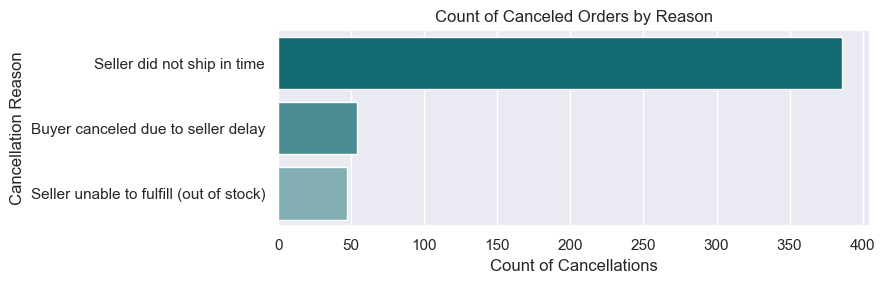

In [17]:
# Determine the order for the bars (sorted by counts, max to min)
reason_order = filtered_cancellations["cancellation_reason"].value_counts().index

# Create the countplot
plt.figure(figsize=(9, 3))

vinted_palette = ["#3E969E", "#017782", "#7AB5BB"]

sns.countplot(
    data=filtered_cancellations,
    y="cancellation_reason",
    order=reason_order,
    palette=vinted_palette,
    hue="cancellation_reason",
    legend=False,
)

plt.title("Count of Canceled Orders by Reason")
plt.xlabel("Count of Cancellations")
plt.ylabel("Cancellation Reason")
plt.tight_layout()
plt.show()

- **"Seller did not ship in time" 79.26%** (386 out of 487) is the Dominant Cancellation Reason.

---

#### 4.7. Days to ship by Seller Rating

In [18]:
# Filter shipped items with valid shipping times
shipped_df = df[df["is_shipped"] & df["days_to_ship"].notna()]

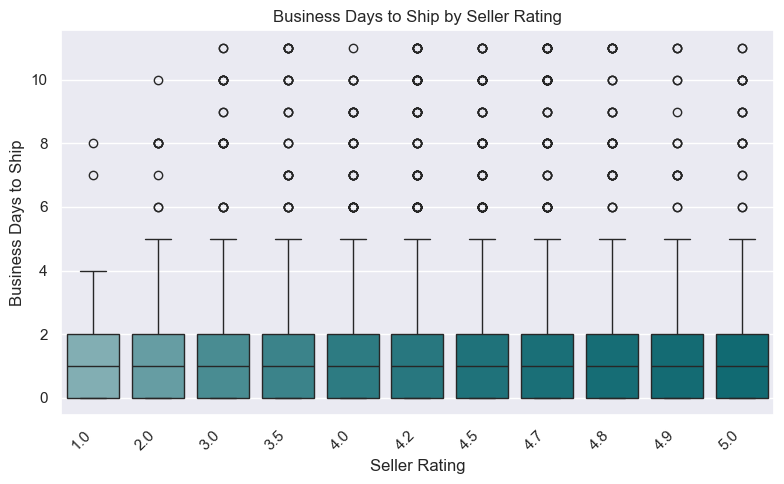

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="seller_rating",
    y="days_to_ship",
    data=shipped_df,
    palette="blend:#7AB5BB,#017782",
    hue="seller_rating",
    legend=False,
)

plt.title("Business Days to Ship by Seller Rating")
plt.xlabel("Seller Rating")
plt.ylabel("Business Days to Ship")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

- Seller rating isn’t a strong predictor of shipping speed in this dataset. Even top-rated sellers don't show substantially faster shipping times.
- Distribution spreads (IQRs) are quite similar across all ratings, meaning variability in shipping time doesn’t change much depending on rating.

---

#### 4.8. Cancellation by Seller Rating

In [20]:
# Filter canceled orders
canceled_df = df[df["is_never_shipped"]]

# Group by seller rating and calculate cancellation rate
cancellation_rate = (
    canceled_df.groupby("seller_rating").size() / df.groupby("seller_rating").size()
).dropna().sort_index()

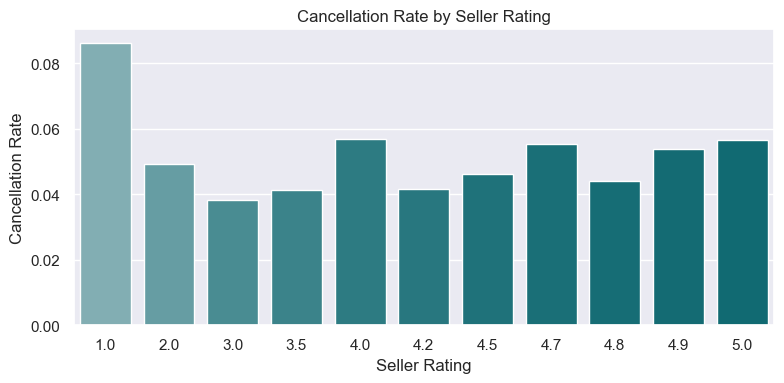

In [21]:
plt.figure(figsize=(8, 4))
sns.barplot(
    x=cancellation_rate.index,
    y=cancellation_rate.values,
    palette="blend:#7AB5BB,#017782",
    hue=cancellation_rate.index,
    legend=False,
)

plt.title("Cancellation Rate by Seller Rating")
plt.xlabel("Seller Rating")
plt.ylabel("Cancellation Rate")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

- Sellers with a 1.0 rating have the highest cancellation rate, suggesting poor reliability.
- High Ratings Don’t Guarantee Low Cancellations
- Increase near 5.0 might suggest, that new sellers with few orders (less data, high initial rating).

---

#### 4.9. Cancellation Rate by Item Category

In [22]:
# Calculates the cancellation rate per item category
category_cancel_rate = (
    df[df["is_never_shipped"]].groupby("item_category", observed=False).size()
    / df.groupby("item_category", observed=False).size()
).dropna().sort_values(ascending=False)

In [23]:
category_cancel_rate

item_category
Men's Clothing      0.055687
Women's Shoes       0.052897
Books               0.052023
Electronics         0.051991
Home Decor          0.050000
Jewellery           0.050000
Beauty Products     0.048447
Women's Clothing    0.046398
Bags                0.045139
Kids' Clothing      0.044100
Accessories         0.043970
Men's Shoes         0.043529
dtype: float64

In [24]:
# Convert the Series to a DataFrame for plotting
category_cancel_rate_df = category_cancel_rate.reset_index()
category_cancel_rate_df.columns = ["item_category", "cancellation_rate"]

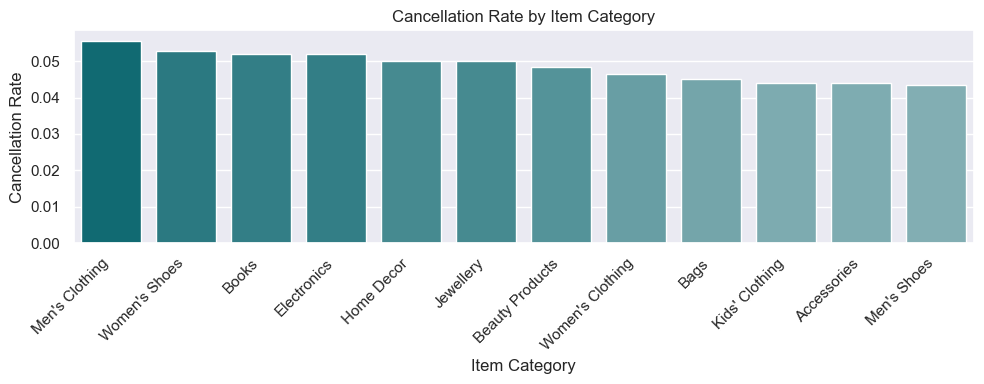

In [25]:
# Plot sorted bar chart
plt.figure(figsize=(10, 4))

sns.barplot(
    x="item_category",
    y="cancellation_rate",
    data=category_cancel_rate_df,
    order=category_cancel_rate.index,
    palette="blend:#7AB5BB,#017782",
    hue="cancellation_rate",
    legend=False
)

plt.title("Cancellation Rate by Item Category")
plt.xlabel("Item Category")
plt.ylabel("Cancellation Rate")
plt.xticks(rotation=45, ha="right") 
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

- *"Men's Clothing"* has the Highest Cancellation Rate 5.57%
- Difference between the highest (5.57%) and lowest (4.35%) cancellation rates is not large (only 1.22 percentage points). This implies that non-shipment is a general issue across categories.

---

#### 4.10. Business Days to Ship by Seller Sales Category

To better understand how seller history influences order fulfillment behavior, I’m categorizing **seller_total_sales** into bins: [0–100], [101–250], [251–500], and [500+]. This allows for clearer comparisons across seller tiers—such as beginners vs. high-performing sellers.

 

In [26]:
# Create a new column 'sales_category' by binning seller_total_sales into defined ranges
bins = [0, 100, 250, 500, df["seller_total_sales"].max()]
labels = ["0-100", "101-250", "251-500", "500+"]
df["sales_category"] = pd.cut(df["seller_total_sales"], bins=bins, labels=labels, right=False)

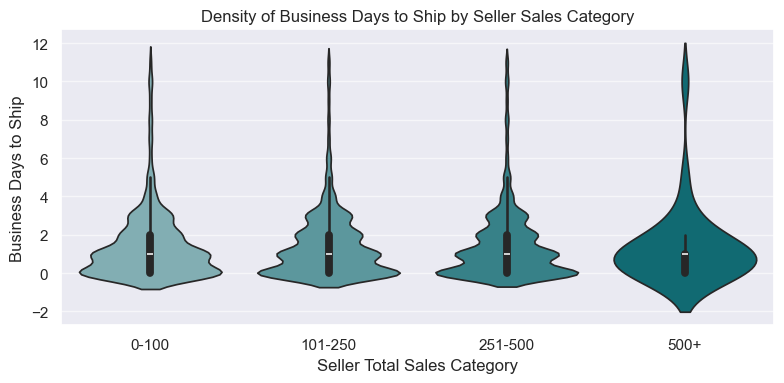

In [27]:
plt.figure(figsize=(8, 4))

sns.violinplot(
    x="sales_category",
    y="days_to_ship",
    data=df,
    palette="blend:#7AB5BB,#017782",
    hue="sales_category",
    legend=False,
)
plt.title("Density of Business Days to Ship by Seller Sales Category")
plt.xlabel("Seller Total Sales Category")
plt.ylabel("Business Days to Ship")
plt.grid(True, axis="y", alpha=0.6)
plt.tight_layout()
plt.show()

- **High-Performing Sellers (500+) are the Most Consistent and Fastest**: its peak heavily concentrated at 0-2 business days.
- Despite the differences in consistency, the primary peak for all seller categories is still at 0-2 business days, indicating that the majority of shipments are processed quickly, even by less experienced sellers. 

---

 ## 5. Correlation between Early Shipping and Non-Shipment

#### 5.1. Non-Shipment

Create a new boolean column ***is_non_shipment*** where:
- True - the order was canceled due to seller non-fulfillment
- False - either the order was shipped, or canceled for unrelated reasons


In [28]:
non_shipment_reasons = [
    "Seller did not ship in time",
    "Seller unable to fulfill (out of stock)",
    "Buyer canceled due to seller delay"
]

df["is_non_shipment"] = (~df["is_shipped"]) & df["cancellation_reason"].isin(non_shipment_reasons)

#### 5.2 Shipping Behavior Classification

Categorize Shipping Behavior:
- Group 1: Orders shipped within 3 days.
- Group 2: Orders not shipped within 3 days (this includes items eventually shipped after 3 days, and items never shipped).

In [29]:
# Define shipping behavior groups
group_1 = (df["is_shipped"] == True) & (df["days_to_ship"] <= 3)
group_2 = ~group_1

df["shipping_behavior_group"] = ""
df.loc[group_1, "shipping_behavior_group"] = "Group 1: Shipped within 3 days"
df.loc[group_2, "shipping_behavior_group"] = "Group 2: After 3 days or never shipped"

In [30]:
# Calculate Non-Shipment Rate per group
non_shipment_rate = (
    df.groupby("shipping_behavior_group")["is_non_shipment"]
    .sum()
    / df.groupby("shipping_behavior_group").size()
).round(4)

print("Non-Shipment Rate by Shipping Behavior Group:")
print(non_shipment_rate)

Non-Shipment Rate by Shipping Behavior Group:
shipping_behavior_group
Group 1: Shipped within 3 days            0.0000
Group 2: After 3 days or never shipped    0.3642
dtype: float64


#### Interpretation:

- Group 1: Shipped within 3 days has a non-shipment rate of 0%. This is expected, as this group definition explicitly includes only orders that were shipped.
- Group 2: After 3 days or never shipped has a non-shipment rate of 0.3642. This means that approximately 36.42% of orders in this group (i.e., those that took longer than 3 days to ship, or were never shipped at all) ultimately result in a non-shipment.

---

This section validates core hypothesis: if an item is not shipped within the initial 3-day window, there's a **36.42% chance** that it will never be shipped at all.

---

### 5.3. Statistical Testing

#### 5.3.1. Chi-Squared Test: shipped within 3 days vs. is non shipment

Note: Chi-Squared assumes independence and expected frequency counts are sufficient.

In [120]:
from scipy.stats import chi2_contingency

In [121]:
# Build contingency table for shipped_within_3_days vs. is_non_shipment
contingency = pd.crosstab(df["shipped_within_3_days"], df["is_non_shipment"])

In [122]:
print(contingency)

is_non_shipment        False  True 
shipped_within_3_days              
False                    850    487
True                    8663      0


In [123]:
# Run a Chi-Squared Test of Independence on contingency table
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"\nChi-Squared Test (vs is_non_shipment):")
print(f"Chi² = {chi2:.4f}, p-value = {p:.4f}, DOF = {dof}")


Chi-Squared Test (vs is_non_shipment):
Chi² = 3309.1645, p-value = 0.0000, DOF = 1


#### Interpretation:

- Since p-value < 0.05, the result is statistically significant — meaning fast shipment behavior and shipment outcome are not independent of each other:
  
     **Orders not shipped within 3 days are highly correlated with cancellations due to seller failure.**
      
- This strong association suggests that delays are a leading indicator of seller unreliability, and could be used as a predictive feature.

---

#### 5.3.2. Cramer's V to quantify the strength of this association.

In [124]:
n = np.sum(contingency, axis=0)
phi2 = chi2 / n
r, k = contingency.shape
cramers_v = np.sqrt(phi2 / min(k - 1, r - 1))

print(f"Cramér's V: {cramers_v.iloc[0]:.3f}")

Cramér's V: 0.590


- A Cramer's V of 0.590 indicates a **strong positive association** between *"shipped within 3 days"* and *"is_non_shipment"*.

#### Interpretation:

In addition to the statistical significance indicated by the p-value, Cramer's V was calculated to quantify the strength of this association. A Cramer's V of 0.590 indicates a strong association between fast shipment behavior and non-shipment outcomes. This further reinforces that whether an order is shipped within three days is a substantial indicator of its likelihood to be successfully completed or result in a cancellation due to seller behavior."

---

### 6. Building Classification Model

The primary objective of this section is to develop a predictive model to identify orders that are likely to be *"never shipped"*.

- **Target Variable (Y):** *is_never_shipped* (Binary: True/False or 1/0).
- **Features (X):** Variables related to seller behavior, item characteristics, and initial shipping timeframe.

The model utilizes the following key features, based on the premise that seller experience and item specifics significantly influence fulfillment reliability:

- *seller_rating*: Higher ratings might correlate with better reliability.
- *seller_total_sales*: Experienced sellers might have smoother operations.
- *item_price*: High-value items might have different fulfillment patterns.
- *item_category*: Some categories might be harder to ship or more prone to issues.

##### **Modeling Assumptions and Data Handling:**

A critical aspect of this analysis concerns the "Initial Shipping Delay." Since the delay itself is often the outcome we are attempting to predict (an indefinite delay signifies the *'never shipped'* state), incorporating this variable directly is problematic. For this exercise, the model relies exclusively on static seller characteristics and item specifics at the time of order placement to predict the likelihood of an order being *'never shipped'*.

---

#### 6.1. Data Preprocessing and Pipeline Setup

In [106]:
df["is_never_shipped_int"] = df["is_never_shipped"].astype(int)

In [107]:
numerical_features = ["seller_rating", "seller_total_sales", "item_price"]
categorical_features = ["item_category"]
target = "is_never_shipped_int"

In [108]:
X = df[numerical_features + categorical_features]
y = df[target]

- StandardScaler for numerical features
- OneHotEncoder for categorical features

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

---

#### 6.2. Split Data (Training and Testing)

In [110]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
"""
Stratify ensures the distribution of 'is_never_shipped' 
is similar in both train/test sets, which is important 
for imbalanced datasets.
"""

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Non-shipment rate in training data: {y_train.mean():.4f}")


Training set size: 8000
Testing set size: 2000
Non-shipment rate in training data: 0.0488


- Training data exhibits severe class imbalance, with *'Never Shipped'* orders representing only 4.88%. This imbalance signals a significant challenge for the model's ability to learn the minority class effectively.

---

#### 6.3. Training the Model

Since we are predicting a **rare event** ***(non-shipment)***, we should look at precision, recall, and the ROC AUC score.

#### 6.3.1. Decision Tree Classifier

In [111]:
# Create the Decision Tree pipeline
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42, max_depth=5)),
    ]
)

# Train the model
dt_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_pipeline.predict(X_test)
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]

In [114]:
# Decision Tree Evaluation
print("\nDecision Tree Performance:")
print(
    classification_report(
        y_test, y_pred_dt, target_names=["Shipped", "Never Shipped"], zero_division=1
    )
)

# Calculate ROC AUC
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
print(f"Decision Tree ROC AUC: {roc_auc_dt:.4f}")


Decision Tree Performance:
               precision    recall  f1-score   support

      Shipped       0.95      1.00      0.97      1903
Never Shipped       0.00      0.00      0.00        97

     accuracy                           0.95      2000
    macro avg       0.48      0.50      0.49      2000
 weighted avg       0.91      0.95      0.93      2000

Decision Tree ROC AUC: 0.4849


##### **Model Failure: The Decision Tree model effectively ignores the minority class** ***"Never Shipped".***
- The support values (1903 *"Shipped"* vs. 97 *"Never Shipped"*) confirm a severe class imbalance.
- The overall accuracy is 0.95, which is misleading because the model achieves this by predicting only the majority class *("Shipped")*.
- The model completely fails to identify the *"Never Shipped"* class (precision, recall, and f1-score all at 0.00).
- ROC AUC is 0.4849, indicating performance equivalent to random guessing

---

#### 6.3.2. Class Weighting

To address the class imbalance implemented *class_weight="balanced"*

In [115]:
# Create the Decision Tree pipeline with Class Weighting
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(
                random_state=42, max_depth=5, class_weight="balanced"
            ),
        ),
    ]
)

# Train the model
dt_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_pipeline.predict(X_test)
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]

In [116]:
# Decision Tree Evaluation
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt, target_names=["Shipped", "Never Shipped"], zero_division=1))

# Calculate ROC AUC
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
print(f"Decision Tree ROC AUC: {roc_auc_dt:.4f}")


Decision Tree Performance:
               precision    recall  f1-score   support

      Shipped       0.96      0.66      0.78      1903
Never Shipped       0.06      0.40      0.10        97

     accuracy                           0.65      2000
    macro avg       0.51      0.53      0.44      2000
 weighted avg       0.91      0.65      0.75      2000

Decision Tree ROC AUC: 0.5301


##### **Class Weighting Effect:** 

- The primary insight shifted **enabling model to detect the** ***"Never Shipped"*** **instances (recall of 0.40).**
- The model is now finding more *"Never Shipped"* instances **but at the expense of precision (0.06)**. This indicates the model is still struggling to accurately differentiate the minority class without generating a high number of false positives.
- This model is more useful because it identifies the minority class, even though its overall accuracy is lower than the baseline model that ignored it entirely.
- Further Optimization is Needed: The overall performance (indicated by the low ROC AUC of 0.5301 and the poor F1-score of 0.10 for *"Never Shipped"*) suggests that a simple decision tree is still not robust enough to effectively classify the minority class.
- Concidering further strategies, such as hyperparameter tuning or alternative modeling approaches.

---

#### 6.3.3. Feature Importance

**Note:** Feature importance is limited because of model's previously established poor performance (low ROC AUC and ineffective classification of the 'Never Shipped' class).

In [118]:
# For a Decision Tree we look at feature importance
dt_classifier = dt_pipeline.named_steps["classifier"]
dt_feature_importances = dt_classifier.feature_importances_

ohe = dt_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_features_ohe = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_features_ohe)

# Map importance scores to feature names
feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": dt_feature_importances
}).sort_values(by="Importance", ascending=False)

print("\nDecision Tree Feature Importance:")
print(feature_importance_df.head(10))


Decision Tree Feature Importance:
                           Feature  Importance
1               seller_total_sales    0.467267
2                       item_price    0.299846
0                    seller_rating    0.041897
9          item_category_Jewellery    0.034040
3        item_category_Accessories    0.028418
4               item_category_Bags    0.028242
13  item_category_Women's Clothing    0.026143
10    item_category_Kids' Clothing    0.024797
12       item_category_Men's Shoes    0.024720
11    item_category_Men's Clothing    0.024631


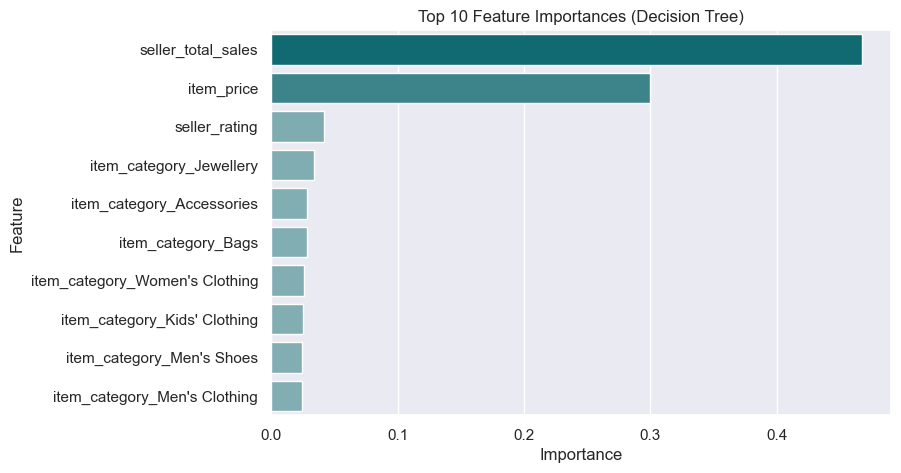

In [119]:
# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(10),
    palette="blend:#7AB5BB,#017782",
    hue="Importance",
    legend=False,
)
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

- While *seller_total_sales* and *item_price* are the most influential features for this model, the model's overall performance suggests that these features are insufficient for accurate and reliable classification.

---

## 7. Main Insights